# Allen Institute
## 08-1_grn_m1_10x
---
- `../data/m1_10x_resampled/resampled`

1. Make GRN
2. Export GRN infomation

In [1]:
import os
import json
from typing import NamedTuple, Dict, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm


from tools.figure import minimal_preset, fig_kwarg
from tools.grn import PCGRN
import tools.spongy_panda as spd

In [2]:
with open("../data/grn_features.json", "r") as f:
    feat = json.load(f)["m1_10x"]
    
feat += minimal_preset

In [3]:
with open("../data/gene_list.json", "r") as f:
    gene_list = json.load(f)

In [4]:
feat = np.array(feat)[
    np.array([
        [v in gene_list[k] for v in feat] for k in gene_list
    ]).all(axis=0)
]

In [5]:
sample_id = "m1_10x"

In [6]:
class Config(NamedTuple):
    data: pd.core.frame.DataFrame = spd.log2normalize(
        spd.load_10xdir(
            "../data/m1_10x_resampled/resampled", from_r=True
        ).loc[:, feat]
    ).to_df()
    label_path: str = "../data/m1_10x_meta/metadata.csv"
    save_dir: str = "../out/m1_10x/08_grn"
    sample_id = sample_id
    fig_kwarg: Dict[str, Union[str, int, float]] = fig_kwarg
    save_file: bool = False

In [7]:
conf = Config(save_file=True)

os.makedirs(conf.save_dir, exist_ok=True)

In [8]:
label = pd.read_csv(
    conf.label_path,
    index_col=0
).class_label.loc[conf.data.index].sort_values()

In [9]:
l_data_sep = [conf.data.loc[label[label == v].index, :] for v in label.unique()]

---
## Calculate and Plot GRNs

Plot GRN:   0%|          | 0/3 [00:00<?, ?it/s]

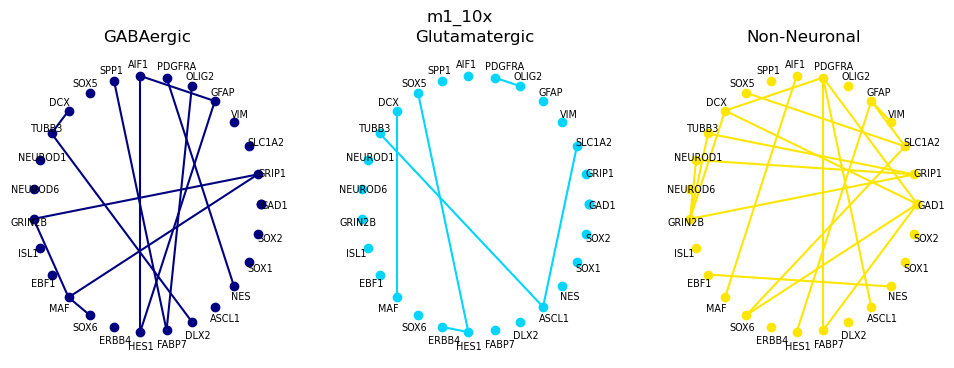

In [10]:
fig, ax = plt.subplots(1, len(l_data_sep), figsize=(4 * len(l_data_sep), 4))

l_model = []

for i, v in tqdm(enumerate(l_data_sep), desc="Plot GRN", total=len(l_data_sep)):
    grn = PCGRN(v)
    grn.estimate()
    
    grn.plot(ax[i], c=plt.cm.jet(i/len(l_data_sep)))
    
    ax[i].set(title=label.sort_values().unique()[i])
    
    l_model += [grn]
    
fig.suptitle(conf.sample_id)

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/grn.png", **conf.fig_kwarg)

---
## Export Results

In [11]:
for i, v in enumerate(l_model):
    v.get_matrix().to_csv(f"{conf.save_dir}/{label.sort_values().unique()[i]}.csv", index=True)